# *ResNet이란?*

기존 CNN은 그냥 쭉 이어진 구조였지만, ResNet은 연산 f(x)를 수행한 후 Input을 다음 층에 더해 준다.

-> Skip connection: 하나의 layer output을 몇 개의 layer를 건너뛴 layer input에 더해주는 것.각 layer가 학습하는 정보량을 줄여준다.

https://velog.io/@lighthouse97/ResNet%EC%9D%98-%EC%9D%B4%ED%95%B4

---

**ResNet110**은 110개의 층으로 구성되어 있기 때문에 epoch 수를 최소 200 이상으로 해야 성능이 좋게 나온다고 함.


---
#SGD + Momentum + CosineAnnealingLR  조합

1. [ResNet110 / epoch 200 / SGD + Momentum + CosineAnnealingLR]
runtime: 3h 20min
---> Accuracy:  88.2%

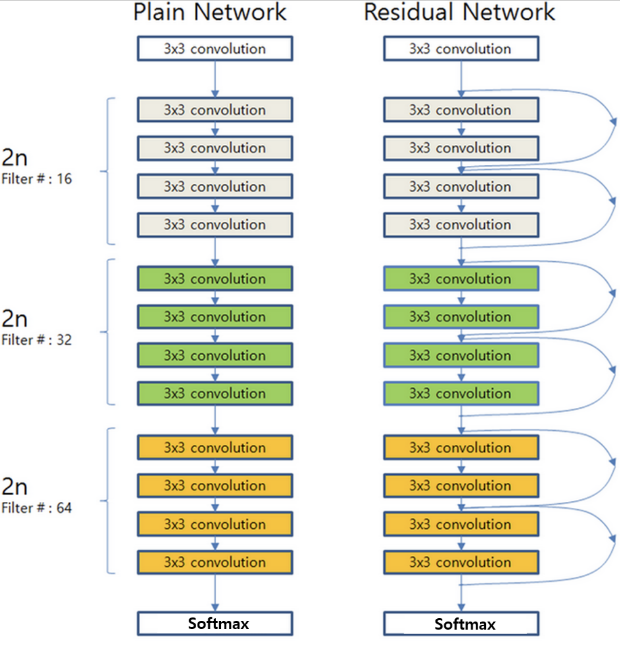

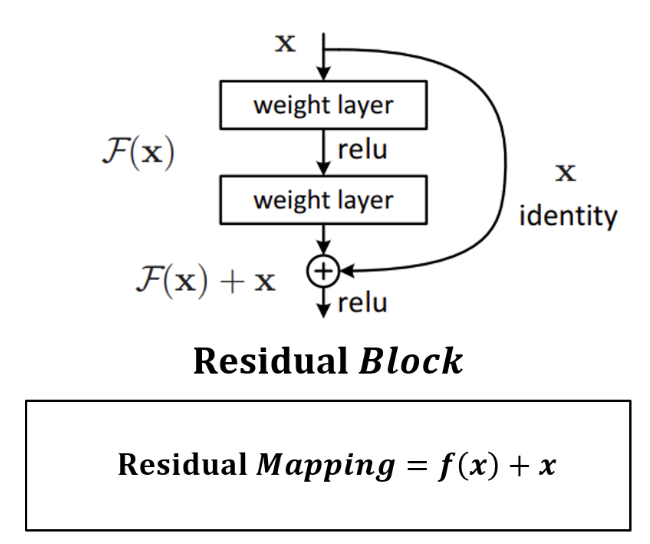

In [34]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

import matplotlib.pyplot as plt
import numpy as np

# data augmentation 수정 (기본 + cutout + autoaugmentation)
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

In [35]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [36]:
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])
transforms_cifar10_training = transforms.Compose([
                                  transforms.RandomCrop(32, padding=4),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5),
                                                        (0.5, 0.5, 0.5))
                                 ])
# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
#배치 사이즈 바꿔도 됨, 셔플은 학습순서 기억하지 못하도록 하기 위해 사용.

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
#배치 사이즈 바꿔도 됨, test는 셔플 필요없음 .

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

 ship plane  deer plane


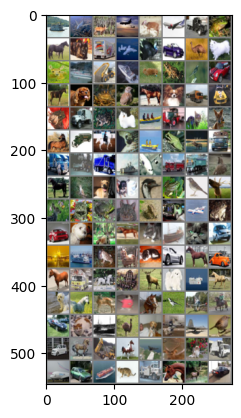

In [37]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [38]:
# data augmentation 수정 (기본 + cutout + autoaugmentation)

class Cutout(object):
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        import numpy as np
        import torch
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        for _ in range(self.n_holes):
            y, x = np.random.randint(h), np.random.randint(w)
            y1, y2 = np.clip(y - self.length // 2, 0, h), np.clip(y + self.length // 2, 0, h)
            x1, x2 = np.clip(x - self.length // 2, 0, w), np.clip(x + self.length // 2, 0, w)
            mask[y1:y2, x1:x2] = 0.
        mask = torch.from_numpy(mask).expand_as(img)
        return img * mask

cutout = Cutout(n_holes=1, length=16)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: cutout(x)),
    transforms.Normalize(mean, std)
])

# 모델 구조/깊이 수정 (ResNet56 + SE + Pre)
# SE(Squeeze-and-Excitation): 각 채널의 중요도 학습 후 -> 덜 중요한 채널 억제 / 중요한 채널 강조 (채널별 attention 역할)

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Pre-activation Basic Block + SE
class PreActBlockSE(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.se = SEBlock(out_planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        out = self.conv1(self.relu1(self.bn1(x)))
        out = self.conv2(self.relu2(self.bn2(out)))
        out = self.se(out)
        shortcut = self.shortcut(x) if isinstance(self.shortcut, nn.Conv2d) else x
        return out + shortcut

# ResNet56 + PreAct + SE 전체 모델
class ResNet56_PreAct_SE(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)

        self.layer1 = self._make_layer(PreActBlockSE, 16, 9, stride=1)
        self.layer2 = self._make_layer(PreActBlockSE, 32, 9, stride=2)
        self.layer3 = self._make_layer(PreActBlockSE, 64, 9, stride=2)

        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_planes, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, out_planes, s))
            self.in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.relu(self.bn(x))  # 마지막 pre-activation
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [39]:
# 모델 정의
net = ResNet56_PreAct_SE().to(device)

# Optimizer + Scheduler 수정
# SGD + Momentum + CosineAnnealingLR 조합
criterion = nn.CrossEntropyLoss()
# 보통 CosineAnnealing은 초기에 큰 learning rate를 사용
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
# CosineAnnealingLR 스케줄러로 변경
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# **Train the network**

Train your own network using the above loss function and optimizer.

In [40]:
# Train the model 그대로 사용
epochs = 200  # number of epochs 바꾸기!!!

for epoch in range(epochs):

    loss_tmp = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = criterion(outputs, labels)

        # Optimize the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.data
        epoch_loss += loss.data

        if i % 5000 == 4999:    # Print loss every 5000 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0

    # Update the learning rate according to the learnig rate scheduler
    scheduler.step()

    # Print the epoch loss
    print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1)))

print('Finished Training')

[Epoch - 1] Loss: 1.424
[Epoch - 2] Loss: 0.938


KeyboardInterrupt: 

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car  ship  ship


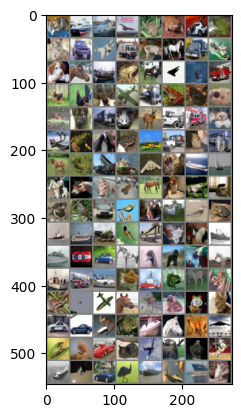

In [41]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [42]:
# Test the trained model with overall test dataset

correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %.1f %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 12 %

Accuracy of the network on the 10,000 test images: 70.2 %
